<a href="https://colab.research.google.com/github/greshav/Exmo/blob/master/Binance_numpy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title
!pip install talib-binary
!pip install mpl_finance
import talib as tb
import pandas as pd
import numpy as np
import requests
import json
import seaborn
import matplotlib.pyplot as plt
from mpl_finance import candlestick2_ohlc
from datetime import datetime

from google.colab import data_table

data_table.enable_dataframe_formatter()

     |████████████████████████████████| 2.4 MB 26.9 MB/s 


In [ ]:
#@title
def technical_indicators_df(daily_data):
        """
        Assemble a dataframe of technical indicator series for a single stock
        """
        o = daily_data['Open'].values
        c = daily_data['Close'].values
        h = daily_data['High'].values
        l = daily_data['Low'].values
        v = daily_data['Volume'].astype(float).values
        # define the technical analysis matrix

        # Most data series are normalized by their series' mean
        ta = pd.DataFrame()
        ta['MA5'] = tb.MA(c, timeperiod=5) / tb.MA(c, timeperiod=5).mean()
        ta['MA10'] = tb.MA(c, timeperiod=10) / tb.MA(c, timeperiod=10).mean()
        ta['MA20'] = tb.MA(c, timeperiod=20) / tb.MA(c, timeperiod=20).mean()
        ta['MA60'] = tb.MA(c, timeperiod=60) / tb.MA(c, timeperiod=60).mean()
        ta['MA120'] = tb.MA(c, timeperiod=120) / tb.MA(c, timeperiod=120).mean()
        ta['MA5'] = tb.MA(v, timeperiod=5) / tb.MA(v, timeperiod=5).mean()
        ta['MA10'] = tb.MA(v, timeperiod=10) / tb.MA(v, timeperiod=10).mean()
        ta['MA20'] = tb.MA(v, timeperiod=20) / tb.MA(v, timeperiod=20).mean()
        ta['ADX'] = tb.ADX(h, l, c, timeperiod=14) / tb.ADX(h, l, c, timeperiod=14).mean()
        ta['ADXR'] = tb.ADXR(h, l, c, timeperiod=14) / tb.ADXR(h, l, c, timeperiod=14).mean()
        ta['MACD'] = tb.MACD(c, fastperiod=12, slowperiod=26, signalperiod=9)[0] / \
                     tb.MACD(c, fastperiod=12, slowperiod=26, signalperiod=9)[0].mean()
        ta['RSI'] = tb.RSI(c, timeperiod=14) / tb.RSI(c, timeperiod=14).mean()
        ta['BBANDS_U'] = tb.BBANDS(c, timeperiod=5, nbdevup=2, nbdevdn=2, matype=0)[0] / \
                         tb.BBANDS(c, timeperiod=5, nbdevup=2, nbdevdn=2, matype=0)[0].mean()
        ta['BBANDS_M'] = tb.BBANDS(c, timeperiod=5, nbdevup=2, nbdevdn=2, matype=0)[1] / \
                         tb.BBANDS(c, timeperiod=5, nbdevup=2, nbdevdn=2, matype=0)[1].mean()
        ta['BBANDS_L'] = tb.BBANDS(c, timeperiod=5, nbdevup=2, nbdevdn=2, matype=0)[2] / \
                         tb.BBANDS(c, timeperiod=5, nbdevup=2, nbdevdn=2, matype=0)[2].mean()
        ta['AD'] = tb.AD(h, l, c, v) / tb.AD(h, l, c, v).mean()
        ta['ATR'] = tb.ATR(h, l, c, timeperiod=14) / tb.ATR(h, l, c, timeperiod=14).mean()
        ta['HT_DC'] = tb.HT_DCPERIOD(c) / tb.HT_DCPERIOD(c).mean()
        ta["High/Open"] = h / o
        ta["Low/Open"] = l / o
        ta["Close/Open"] = c / o
        return ta

In [ ]:
#@title
def check_pair(pair="MIRBUSD", interval='1m'):
    limit = 12 * 60
    url = f"https://www.binance.com/api/v3/klines?symbol={pair}&interval={interval}&limit={limit}"
    req = json.loads(requests.get(url).text)
    data = pd.DataFrame(req)
    data = data[[0,1,2,3,4,5]].rename(columns={0: "Open_Time", 1: "Open", 2: "High", 3: "Low", 4: "Close", 5: "Volume"})
    data["Open"] = data["Open"].astype(np.float64)
    data["High"] = data["High"].astype(np.float64)
    data["Low"] = data["Low"].astype(np.float64)
    data["Close"] = data["Close"].astype(np.float64)
    data["Volume"] = data["Volume"].astype(np.float64)
    return data

In [ ]:
#@title
#m = [c.Open_Time[c.index == i] for i, x in enumerate(ADX) if x > 70]
#[str(datetime.fromtimestamp(int(x / 1000))) for x in m]

In [ ]:
#@title
def loadTicker():
    req = requests.get("https://www.binance.com/api/v3/ticker/24hr")
    return json.loads(req.text)

def readTicker():
    with open("Ticker.json", "r") as f:
        return json.load(f)

In [ ]:
#@title
rt = loadTicker()
x = pd.DataFrame(rt)
y = x

x.askPrice = x.askPrice.astype(np.float64)
x.lastPrice = x.lastPrice.astype(np.float64)
x.bidPrice = x.bidPrice.astype(np.float64)
x.lastPrice = x.lastPrice.astype(np.float64)
x.volume = x.volume.astype(np.float64)
x.highPrice = x.highPrice.astype(np.float64)
x.lowPrice = x.lowPrice.astype(np.float64)
x.weightedAvgPrice = x.weightedAvgPrice.astype(np.float64)
x.priceChange = x.priceChange.astype(np.float64)
x.priceChangePercent = x.priceChangePercent.astype(np.float64)
#x['above_middle'] = (x.bidPrice + x.askPrice) / 2 / x.weightedAvgPrice
x['percent_buy_sell'] = round((x.askPrice / x.bidPrice - 1) * 100, 2)
x['min_max_24h'] = round((x.highPrice / x.lowPrice) * 100, 0)
x.insert(1, 'buy_sell', x.weightedAvgPrice < ((x.bidPrice + x.askPrice) / 2))

x = x[x.bidPrice != 0]
x = x[x.askPrice != 0]
x = x[x.min_max_24h != np.NaN]
x = x[x.volume > 0]
x = x[x.buy_sell > 0]

x = x[['symbol', 'buy_sell', 'priceChange',
       'percent_buy_sell', 'priceChangePercent',
       'bidPrice', 'askPrice', 'openPrice','highPrice',
       'lowPrice', 'volume', 'openTime', 'closeTime', 'count',
       'askQty', 'bidQty', 'weightedAvgPrice']]

data_table.DataTable(x.sort_values(by='priceChangePercent', ascending=False), include_index=False, num_rows_per_page=15)
#check_pair()
#s = x[x.priceChangePercent == max(x.priceChangePercent)]
#x[x.lastPrice > 0]#.sort_values(by='askPrice', ascending=False)
#x[x.buy_sell > 0]#.sort_values(by='priceChangePercent', ascending=False)
#x[x.priceChangePercent > 0.5].sort_values(by='priceChangePercent', ascending=False)

filter = 'USDT'
x = x[x.symbol.str.find(filter) > 0]
#x = x[x.priceChangePercent > 10]
#x = x[x.bidPrice < x.weightedAvgPrice]

data_table.DataTable(x.sort_values(by='priceChangePercent', ascending=False), include_index=False, num_rows_per_page=20)
#data_table.DataTable(x[['symbol', 'min_max_24h', 'buy_sell', 'askPrice', 'bidPrice', 'priceChangePercent', 'volume']].sort_values(by='min_max', ascending=False), include_index=False, num_rows_per_page=10)

,symbol,buy_sell,priceChange,percent_buy_sell,priceChangePercent,bidPrice,askPrice,openPrice,highPrice,lowPrice,volume,openTime,closeTime,count,askQty,bidQty,weightedAvgPrice
1369,EPSUSDT,True,0.03750,0.11,24.526,0.19040,0.19060,0.15290000,0.20760,0.15000,1.801189e+08,1651774413894,1651860813894,135437,2461.00000000,546.00000000,0.184805
1013,TRXUPUSDT,True,0.01480,0.32,17.565,0.09899,0.09931,0.08426000,0.11000,0.07977,6.760306e+07,1651774414954,1651860814954,29770,4208.37000000,121.07000000,0.093443
1486,TORNUSDT,True,5.69000,0.02,11.258,56.23000,56.24000,50.54000000,58.70000,49.60000,1.792002e+05,1651774391208,1651860791208,48772,118.61000000,1.81000000,54.703478
350,TRXUSDT,True,0.00775,0.01,10.561,0.08112,0.08113,0.07338000,0.08663,0.07158,6.083178e+09,1651774415145,1651860815145,896781,23556.80000000,23249.30000000,0.078894
541,ALGOUSDT,True,0.06460,0.01,10.310,0.69130,0.69140,0.62660000,0.70870,0.61420,1.019014e+08,1651774414496,1651860814496,273498,521.00000000,1226.00000000,0.657225
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1757,PORTOUSDT,True,-0.09960,0.19,-3.073,3.14130,3.14730,3.24070000,3.38030,3.00890,1.236057e+06,1651774415098,1651860815098,18115,3.70000000,116.32000000,3.138552
1697,LAZIOUSDT,True,-0.11720,0.13,-3.793,2.96910,2.97290,3.09020000,3.12780,2.86470,1.002373e+06,1651774408925,1651860808925,20188,94.12000000,4.25000000,2.967880
1572,FARMUSDT,True,-3.30000,0.13,-4.039,78.40000,78.50000,81.70000000,81.70000,75.60000,1.476539e+04,1651774392858,1651860792858,6905,5.78000000,0.16700000,78.358339
1684,RAREUSDT,True,-0.02100,0.25,-4.976,0.40000,0.40100,0.42200000,0.42400,0.37600,8.026180e+06,1651774398225,1651860798225,12016,2100.00000000,36530.00000000,0.396805


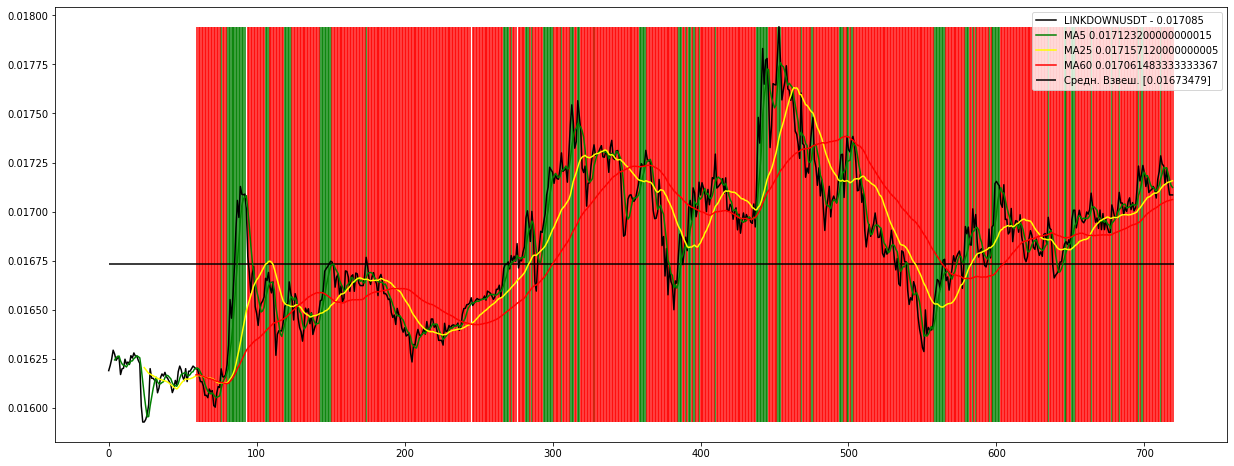

In [ ]:
#@title График MA5, MA25, MA60 { display-mode: "form" }
pair = "LINKDOWNUSDT" #@param {type:"string"}
interval = "1m" #@param {type:"string"}
percent = 1.005
c = check_pair(pair, interval)#[-240:]

MA5 = tb.MA(c.Close, 5)
MA9 = tb.MA(c.Close, 9)
MA25 = tb.MA(c.Close, 25)
MA60 = tb.MA(c.Close, 60)
macd, signal, hist = tb.MACD(c['Close'], 5, 25, 9)
RSI = tb.RSI(c.Close, 12)

up = []
down = []

for i in range(60,len(c)):
  condition_up = (c.Close[i] / MA9[i] > 1.005)# and macd[i] > signal[i]# and RSI[i] > 70# and macd[i] > signal[i]: # and MA5[i]/MA25[i] > 1.005 and hist[i] > 0:
  if condition_up:
    up.append(i)
  elif c.Close[i] < MA9[i] or RSI[i] < 70: #MA5[i] < MA25[i]:
    down.append(i)

fig, ax = plt.subplots()

ax.plot(c["Close"], color="black", label=f"{pair} - {c.Close[len(c.Close)-1]}")
ax.plot(MA5, color="green", label=f"MA5 {MA5[len(MA5) - 1]}")
ax.plot(MA25, color="yellow", label=f"MA25 {MA25[len(MA25) - 1]}")
ax.plot(MA60, color="red", label=f"MA60 {MA60[len(MA60)-1]}")

ax.vlines(up, min(c["Close"]), max(c["Close"]), color='green',)
ax.vlines(down, min(c["Close"]), max(c["Close"]), color='red')
ax.hlines(y[y.symbol == pair].weightedAvgPrice, 0, len(c), label=f"Средн. Взвеш. {y[y.symbol == pair].weightedAvgPrice.values}")
ax.legend()

fig.set_figheight(8)
fig.set_figwidth(21)
plt.show()

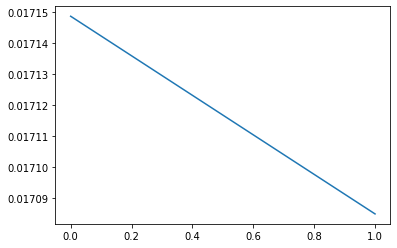

In [ ]:
period = 5
plt.plot([c.Close.values[-period:-round(period / 2)].mean(), c.Close.values[-round(period / 2):].mean()])
#f, ax = plt.subplots(figsize = (20, 6))
#plt.plot(tb.RSI(c.Close, 12))
#ax.plot(c.Close)

#f, ax = plt.subplots(figsize = (20, 6))
#seaborn.set_color_codes('dark')
#seaborn.barplot(x='Open_Time', y='Volume', data=c)

#c.Open_Time = c.Open_Time.astype(str)
#plt.plot(c.Open_Time, c.Close)
#from numpy.core.fromnumeric import size
#print(pd.to_numeric(x.bidQty))
#check_pair(pd.Index(x['symbol'][x.priceChangePercent == max(x.priceChangePercent)]).values[0], "1m")
#check_pair("ALPINEUSDT", "1m")

In [ ]:
#@title
#x.select_dtypes(include=['int64', 'float64', 'int'])
#x.columns.tolist()
'''
x = x[['symbol', 'priceChange', 'min_max_24h', 'percent_buy_sell', 'priceChangePercent', 'buy_sell', 'bidPrice', 'askPrice', 'openPrice',
 'highPrice', 'lowPrice', 'volume', 'openTime', 'closeTime', 'count', 'askQty', 'bidQty', 'weightedAvgPrice']]
x = x[x.buy_sell > 0]
x = x[x.percent_buy_sell != np.NaN]
x = x[x.min_max_24h != np.NaN]
x = x[x.volume > 0]
data_table.DataTable(x, include_index=False, num_rows_per_page=10)'''

"\nx = x[['symbol', 'priceChange', 'min_max_24h', 'percent_buy_sell', 'priceChangePercent', 'buy_sell', 'bidPrice', 'askPrice', 'openPrice',\n 'highPrice', 'lowPrice', 'volume', 'openTime', 'closeTime', 'count', 'askQty', 'bidQty', 'weightedAvgPrice']]\nx = x[x.buy_sell > 0]\nx = x[x.percent_buy_sell != np.NaN]\nx = x[x.min_max_24h != np.NaN]\nx = x[x.volume > 0]\ndata_table.DataTable(x, include_index=False, num_rows_per_page=10)"

In [ ]:
#@title
#x[['symbol', 'askPrice', 'bidPrice', 'Percent']]
#x[['symbol', 'min_max', 'buy_sell', 'askPrice', 'bidPrice', 'percent', 'volume']].sort_values(by='min_max', ascending=False)#[:20]
#list(x[x.Percent > 1].sort_values(by='Percent', ascending=False).symbol)

In [ ]:
#@title
'''
s = pd.date_range('2022-03-04', '2022-03-04 11:00', freq='H') #.Series({'BTC_USDT':60000, 'ALGO_USD':15000, 'BTC_USD':62000})
x = pd.Series([1,2,3,4,5,6,7,8,8,9,10,11], s)
y = pd.Series([1,2,3,4,5,6,7,8,9,10,11,12], s)
df = pd.DataFrame({'One':x, 'Two':y})
df['Middle'] = df['One'] // df['Two']
df['2022-03-04 01:00':'2022-03-04 06:00']'''

"\ns = pd.date_range('2022-03-04', '2022-03-04 11:00', freq='H') #.Series({'BTC_USDT':60000, 'ALGO_USD':15000, 'BTC_USD':62000})\nx = pd.Series([1,2,3,4,5,6,7,8,8,9,10,11], s)\ny = pd.Series([1,2,3,4,5,6,7,8,9,10,11,12], s)\ndf = pd.DataFrame({'One':x, 'Two':y})\ndf['Middle'] = df['One'] // df['Two']\ndf['2022-03-04 01:00':'2022-03-04 06:00']"